# classification-09

## What's new:

1- https://chatgpt.com/c/690b9614-4bcc-8325-9740-33b182ae64ce

## next step:

1- Improve labeling ( 3333 from 28-1111 )


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda, RepeatVector
from tensorflow.keras import Input, layers, models, callbacks, losses, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split



In [ ]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [ ]:
df.shape

In [ ]:
import matplotlib.pyplot as plt

# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [7]:
def label_reversal_points(prices, window=6, threshold=0.0007):
    """
    Labels trend reversals (1=Buy, 2=Sell) based on local mean shifts.
    Smaller window & threshold increase sensitivity.
    """
    prices = np.asarray(prices)
    labels = [0] * len(prices)
    prev_trend = 0  # 1 = up, -1 = down, 0 = unknown

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            curr_trend = 1  # Uptrend
        elif change < -threshold:
            curr_trend = -1  # Downtrend
        else:
            curr_trend = 0  # No significant trend

        # Detect reversal only when trend flips clearly
        if prev_trend == -1 and curr_trend == 1:
            labels[i + window // 2] = 1  # Buy
        elif prev_trend == 1 and curr_trend == -1:
            labels[i + window // 2] = 2  # Sell

        if curr_trend != 0:
            prev_trend = curr_trend

    return labels


df_model['Label'] = label_reversal_points(df_model['CLOSE'].values)

In [8]:
print(df_model['Label'].value_counts().sort_index())  # 0, 1, 2

Label
0    130688
1      7834
2      7834
Name: count, dtype: int64


In [9]:
import matplotlib.pyplot as plt


def plot_labeled_candles(df, n=190):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



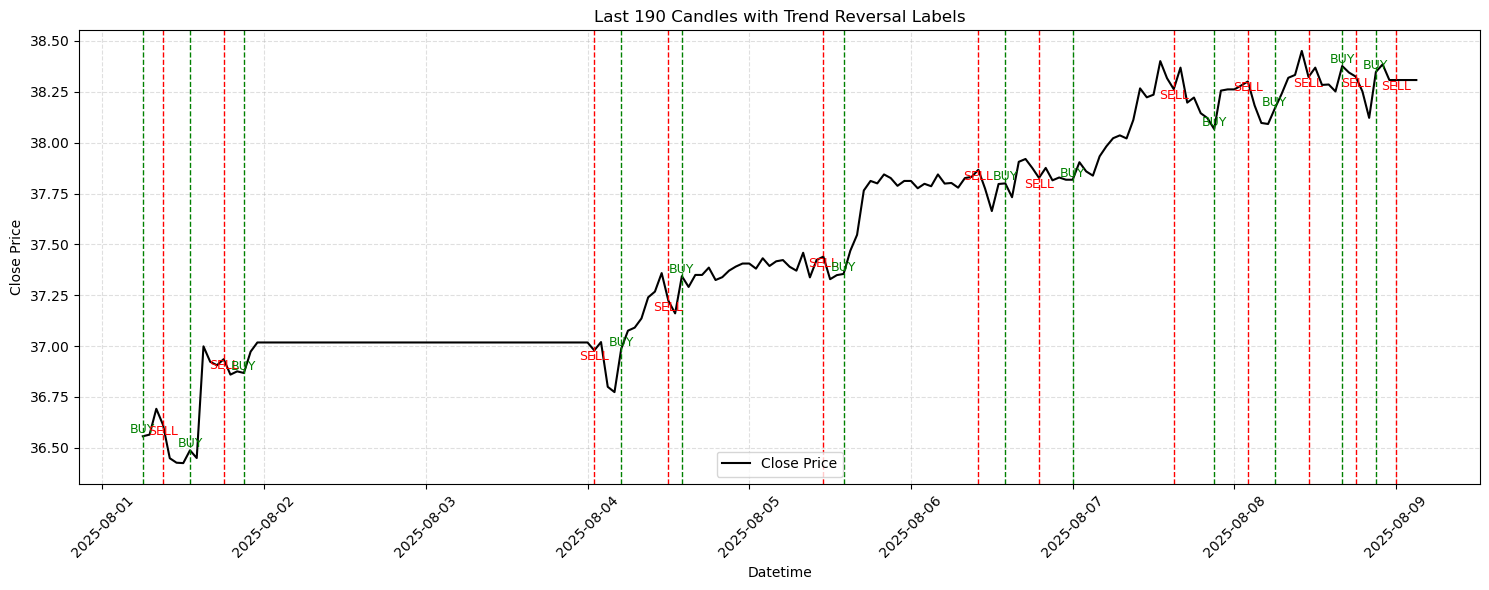

In [10]:
plot_labeled_candles(df_model)

In [11]:
# === UPDATED MODEL (Attention + Focal Loss + Label Smoothing) + PREDICTION PIPELINE ===
# Assumes df_model exists in session with columns:
# ['DATETIME','DATE','TIME','OPEN','HIGH','LOW','CLOSE','TICKVOL','VOL','SPREAD','Label']

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --------------------------
# Config
# --------------------------
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN','HIGH','LOW','CLOSE','TICKVOL']
NUM_CLASSES = 3
RANDOM_STATE = 42
BATCH_SIZE = 128
EPOCHS = 20
LABEL_SMOOTHING = 0.05  # small smoothing
TEMPERATURE = 1.4       # >1 softens predictions
LEARNING_RATE = 1e-4

# --------------------------
# Ensure DATETIME dtype and sort
# --------------------------
if not np.issubdtype(df_model['DATETIME'].dtype, np.datetime64):
    df_model['DATETIME'] = pd.to_datetime(df_model['DATETIME'], errors='coerce')
df_model = df_model.sort_values('DATETIME').reset_index(drop=True)

# --------------------------
# Build sliding-window dataset
# --------------------------
def build_dataset(df, features, label_col='Label', window_size=WINDOW_SIZE, horizon=FORECAST_HORIZON):
    X_list = []
    y_list = []
    datetimes_y = []
    n = len(df)
    start_i = window_size - 1
    end_i = n - horizon - 1
    if end_i < start_i:
        raise ValueError("Not enough data to build any sample. Check df length vs window/horizon.")
    for i in range(start_i, end_i + 1):
        wstart = i - window_size + 1
        wend = i + 1
        X = df.iloc[wstart:wend][features].values  # (window_size, features)
        y = df.iloc[i+1 : i+1+horizon][label_col].values
        if len(y) != horizon:
            continue
        X_list.append(X)
        y_list.append(y.astype(int))
        datetimes_y.append(df.iloc[i+1]['DATETIME'])
    X_arr = np.stack(X_list)
    y_arr = np.stack(y_list)
    return X_arr, y_arr, np.array(datetimes_y)

X_all, y_all, datetimes_all = build_dataset(df_model, FEATURES)
print("Dataset shapes -> X:", X_all.shape, "y:", y_all.shape)

Dataset shapes -> X: (146287, 60, 5) y: (146287, 10)


In [12]:
# --------------------------
# Train/val split
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.12, random_state=RANDOM_STATE, shuffle=True
)
print("Train/Val:", X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# --------------------------
# Scaling
# --------------------------
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
def scale_X(X, scaler):
    return scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
X_train_scaled = scale_X(X_train, scaler)
X_val_scaled = scale_X(X_val, scaler)

# --------------------------
# Label smoothing + one-hot
# --------------------------
def smooth_one_hot(y_int, num_classes=NUM_CLASSES, smoothing=LABEL_SMOOTHING):
    # y_int shape: (n_samples, horizon)
    n, h = y_int.shape
    y_oh = tf.keras.utils.to_categorical(y_int, num_classes=num_classes).reshape(n, h, num_classes).astype(np.float32)
    if smoothing > 0:
        y_oh = y_oh * (1.0 - smoothing) + (smoothing / num_classes)
    return y_oh

y_train_cat = smooth_one_hot(y_train, NUM_CLASSES, LABEL_SMOOTHING)
y_val_cat = smooth_one_hot(y_val, NUM_CLASSES, LABEL_SMOOTHING)

# --------------------------
# Optional: compute class weights & sample weights (keeps previous behavior available)
# --------------------------
flattened = y_train.flatten()
unique, counts = np.unique(flattened, return_counts=True)
freq = dict(zip(unique, counts))
total = flattened.size
class_weight = {int(cls): float(total / (len(unique) * cnt)) for cls, cnt in freq.items()}
print("class_weight:", class_weight)

def make_sample_weights(y_int, class_weight_dict):
    sw = np.zeros_like(y_int, dtype=np.float32)
    for c, w in class_weight_dict.items():
        sw[y_int == c] = w
    return sw

sample_weight_train = make_sample_weights(y_train, class_weight)
sample_weight_val = make_sample_weights(y_val, class_weight)

# --------------------------
# Focal loss implementation (categorical, for one-hot y)
# --------------------------
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=[0.1, 0.6, 0.6]):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_mean(tf.reduce_sum(weight * cross_entropy, axis=-1))
    return loss_fn

# Example: emphasize classes 1 & 2 more than 0 (tuned heuristically)
alpha_for_focal = [0.12, 0.44, 0.44]  # sum not required to be 1; tune as needed

Train/Val: (128732, 60, 5) (17555, 60, 5) (128732, 10) (17555, 10)
class_weight: {0: 0.3733300388694537, 1: 6.232124011192766, 2: 6.213264217694955}


In [13]:
# --------------------------
# Build model: Conv -> BiLSTM(seq) -> Attention Residual -> BiLSTM -> Dense -> Repeat -> Decoder LSTM
# --------------------------
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Bidirectional, LSTM, Dropout, Dense, RepeatVector, TimeDistributed, LayerNormalization, Add, Attention

tf.keras.backend.clear_session()
inp = Input(shape=(WINDOW_SIZE, len(FEATURES)), name='input_sequence')
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inp)
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
# BiLSTM with return_sequences for attention
x_seq = Bidirectional(LSTM(128, return_sequences=True))(x)  # (None, WINDOW_SIZE, 256)
# Self-attention (query/key/value all x_seq)
attn_out = Attention()([x_seq, x_seq])  # (None, WINDOW_SIZE, 256)
# Residual + LayerNorm
x_res = Add()([x_seq, attn_out])
x_res = LayerNormalization()(x_res)
# Pool down with second BiLSTM to a vector
x_enc = Bidirectional(LSTM(64, return_sequences=False))(x_res)  # (None, 128)
x_enc = Dense(128, activation='relu')(x_enc)
x_enc = Dropout(0.3)(x_enc)
x_rep = RepeatVector(FORECAST_HORIZON)(x_enc)  # (None, horizon, 128)
# Decoder
x_dec = LSTM(128, return_sequences=True)(x_rep)
x_dec = Dropout(0.3)(x_dec)
x_dec = TimeDistributed(Dense(64, activation='relu'))(x_dec)
out = TimeDistributed(Dense(NUM_CLASSES, activation='softmax'), name='predictions')(x_dec)

model = models.Model(inp, out)
model.summary()


I0000 00:00:1762490625.022738    6193 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2387 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 64)    │      1,024 │ input_sequence[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 60, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 60, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 256)   │    197,632 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 256)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 256)   │          0 │ bidirectional[0]… │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 256)   │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 10, 128)   │          0 │ dropout[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 10, 128)   │    131,584 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 128)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 10, 64)    │      8,256 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions         │ (None, 10, 3)     │        195 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 532,675 (2.03 MB)

 Trainable params: 532,547 (2.03 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:

# --------------------------
# Compile with focal loss
# --------------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=focal_loss(gamma=2.0, alpha=alpha_for_focal),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='cat_acc')]
)

# --------------------------
# Callbacks
# --------------------------
es = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
ckpt = callbacks.ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

# --------------------------
# Fit model
# Note: we pass sample_weight (n_samples, horizon) so Keras will apply per-timestep weighting.
# --------------------------
history = model.fit(
    X_train_scaled,
    y_train_cat,
    sample_weight=sample_weight_train,
    validation_data=(X_val_scaled, y_val_cat, sample_weight_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr, ckpt],
    verbose=1
)

In [15]:


# --------------------------
# PREDICTION: prepare a single input window given_time and produce predicted_df
# --------------------------
given_time = "2025.07.24 11:00:00"   # user-provided (space format)
given_ts = pd.to_datetime(given_time, format="%Y.%m.%d %H:%M:%S", errors='coerce')
if pd.isna(given_ts):
    given_ts = pd.to_datetime(given_time, errors='coerce')
if pd.isna(given_ts):
    raise ValueError("given_time cannot be parsed. Use 'YYYY.MM.DD HH:MM:SS' or similar.")

matches = df_model.index[df_model['DATETIME'] == given_ts].tolist()
if len(matches) == 0:
    raise ValueError(f"given_time {given_ts} not found exactly in df_model['DATETIME'].")
idx = matches[0]
if idx - (WINDOW_SIZE - 1) < 0:
    raise ValueError("Not enough past candles before given_time to build input window (need 60 candles).")

window_slice = df_model.iloc[idx - (WINDOW_SIZE - 1) : idx + 1]
X_input = window_slice[FEATURES].values
X_input_scaled = scaler.transform(X_input).reshape(1, WINDOW_SIZE, len(FEATURES))

# run prediction
y_pred_prob = model.predict(X_input_scaled)  # (1, horizon, classes)
y_pred_prob = np.squeeze(y_pred_prob, axis=0)  # (horizon, classes)

# Temperature scaling (soften probabilities to reduce overconfidence)
def apply_temperature(probs, T=TEMPERATURE):
    # probs shape: (horizon, classes)
    logits = np.log(np.clip(probs, 1e-9, 1.0))
    scaled = np.exp(logits / T)
    scaled = scaled / np.sum(scaled, axis=-1, keepdims=True)
    return scaled

y_pred_prob_cal = apply_temperature(y_pred_prob, T=TEMPERATURE)
pred_classes = np.argmax(y_pred_prob_cal, axis=-1)

# Build predicted_df
forecast_datetimes = pd.date_range(start=given_ts + pd.Timedelta(hours=1), periods=FORECAST_HORIZON, freq='h')
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})
predicted_df[['prob_0','prob_1','prob_2']] = pd.DataFrame(y_pred_prob_cal, columns=['prob_0','prob_1','prob_2'])

# Optional: quick plot for review (uncomment to show)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,3))
# plt.plot(predicted_df['DATETIME'], predicted_df['prob_1'], label='Buy prob')
# plt.plot(predicted_df['DATETIME'], predicted_df['prob_2'], label='Sell prob')
# plt.legend(); plt.grid(True); plt.title('Predicted buy/sell probabilities (temperature-scaled)')

# Show predicted_df as the final object
predicted_df


I0000 00:00:1762490655.583092    6369 cuda_dnn.cc:529] Loaded cuDNN version 91301


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


,DATETIME,forecast_class,prob_0,prob_1,prob_2
0,2025-07-24 12:00:00,0,0.418557,0.289511,0.291932
1,2025-07-24 13:00:00,0,0.419795,0.290079,0.290126
2,2025-07-24 14:00:00,0,0.419883,0.290906,0.289211
3,2025-07-24 15:00:00,0,0.419443,0.292275,0.288282
4,2025-07-24 16:00:00,0,0.420456,0.292427,0.287117
5,2025-07-24 17:00:00,0,0.421546,0.292260,0.286194
6,2025-07-24 18:00:00,0,0.423160,0.291534,0.285307
7,2025-07-24 19:00:00,0,0.424841,0.290739,0.284420
8,2025-07-24 20:00:00,0,0.426539,0.289955,0.283505
9,2025-07-24 21:00:00,0,0.428188,0.289200,0.282612


# plot section

In [ ]:
# --------------------------
# === Visualization Block ===
# --------------------------
import pandas as pd
import sys

# --- 1. Historical window (last 4 real candles before forecast) ---
# --- Find the starting index ---
start_idx = df.index[df['DATETIME'] == pd.to_datetime(given_time)][0]

# --- 1. Extract next n candles ---
input_df = df.iloc[start_idx : start_idx + WINDOW_SIZE].copy()
historical_df = input_df.tail(4).copy()
historical_df

In [ ]:
# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = start_idx
actual_future_end = start_idx + FORECAST_HORIZON
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()
actual_future_df

In [22]:
# --- 3. Create predicted_df (forecast for next 10 hours) ---
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq='h'
)

# --- 4. Add text labels for clarity ---
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None


predicted_df['label'] = predicted_df['pred_label'].apply(class_to_label)

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



KeyError: 'pred_label'

In [ ]:
# --- 6. Import your plotting utility ---
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [ ]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()



# 4. Evaluate on validation set (since no X_test/y_test defined)
final_train_loss = history.history['loss'][-1]
final_train_acc  = history.history['cat_acc'][-1]
final_val_loss, final_val_acc = model.evaluate(X_val_scaled, y_val_cat, verbose=0)

# 5. Save model summary and performance metrics
summary_path = os.path.join(log_dir, 'model_log.txt')
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('\n')
    f.write(f'Final Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Training Accuracy: {final_train_acc:.6f}\n')
    f.write(f'Final Validation Loss: {final_val_loss:.6f}\n')
    f.write(f'Final Validation Accuracy: {final_val_acc:.6f}\n')

In [14]:
model_path = 'saved_models/model_20251106_214146.keras'
model = keras.models.load_model(
    model_path,
    custom_objects={'loss_fn': focal_loss(), 'focal_loss': focal_loss()},
    safe_mode=False
)